In [63]:
import seaborn as sns
import pandas as pd
import pyspark.sql.functions as F
import matplotlib.pyplot as plt


In [3]:
data = "gs://pstat135-group22/notebooks/jupyter/data/"

In [4]:
data_dict = spark.read.format("csv")\
    .option("header", "true")\
  .option("nullValue", "NA")\
  .load(data+"VM2Uniform--MI--2021-01-30/VM2Uniform--MI--2021-01-30_DataDictionary.csv")

data_dict.show(5)

+--------------------+---+---+---+
|            L2, Inc.|_c1|_c2|_c3|
+--------------------+---+---+---+
|18912 North Creek...|   |   |   |
|   Bothell, WA 98011|   |   |   |
|Phone: (800) 842-...|   |   |   |
|Web: WWW.L2POLITI...|   |   |   |
|                    |   |   |   |
+--------------------+---+---+---+
only showing top 5 rows



In [4]:
# bucket_dir = "gs://pstat135-voter-file/VM2Uniform/"
# df = spark.read.parquet(bucket_dir + 'VM2Uniform--AK--2021-02-03')
# df.select(*["General_2020", "Voters_Age", "Voters_Gender","County", "Voters_Active"]).show(5)


+------------+----------+-------------+--------------------+-------------+
|General_2020|Voters_Age|Voters_Gender|              County|Voters_Active|
+------------+----------+-------------+--------------------+-------------+
|           Y|        70|            M|FAIRBANKS NORTH STAR|            A|
|           Y|      null|            F|FAIRBANKS NORTH STAR|            A|
|           Y|        72|            F|FAIRBANKS NORTH STAR|            A|
|           Y|        59|            M|FAIRBANKS NORTH STAR|            A|
|           Y|        51|            F|FAIRBANKS NORTH STAR|            A|
+------------+----------+-------------+--------------------+-------------+
only showing top 5 rows



In [5]:
# MI - Michigan -- Swing State
mi_df = spark.read\
    .format("csv")\
    .option("header", "true")\
    .option("nullValue", "NA")\
    .option("delimiter", "\t")\
    .option("inferSchema", "true")\
    .load(data+"VM2Uniform--MI--2021-01-30/VM2Uniform--MI--2021-01-30.tab")


In [6]:
# SC - South Carolina -- Rep. State
sc_df = spark.read\
    .format("csv")\
    .option("header", "true")\
    .option("nullValue", "NA")\
    .option("delimiter", "\t")\
    .option("inferSchema", "true")\
    .load(data+"VM2Uniform--SC--2021-04-16/VM2Uniform--SC--2021-04-16.tab")

In [7]:
# MD - Maryland -- Dem State
md_df = spark.read\
    .format("csv")\
    .option("header", "true")\
    .option("nullValue", "NA")\
    .option("delimiter", "\t")\
    .option("inferSchema", "true")\
    .load(data+"VM2Uniform--MD--2021-02-15/VM2Uniform--MD--2021-02-15.tab")

In [8]:
mi_df.printSchema()

root
 |-- SEQUENCE: integer (nullable = true)
 |-- LALVOTERID: string (nullable = true)
 |-- Voters_Active: string (nullable = true)
 |-- Voters_StateVoterID: long (nullable = true)
 |-- Voters_CountyVoterID: string (nullable = true)
 |-- VoterTelephones_LandlineAreaCode: integer (nullable = true)
 |-- VoterTelephones_Landline7Digit: string (nullable = true)
 |-- VoterTelephones_LandlineFormatted: string (nullable = true)
 |-- VoterTelephones_LandlineUnformatted: long (nullable = true)
 |-- VoterTelephones_LandlineConfidenceCode: integer (nullable = true)
 |-- VoterTelephones_CellPhoneOnly: boolean (nullable = true)
 |-- VoterTelephones_CellPhoneFormatted: string (nullable = true)
 |-- VoterTelephones_CellPhoneUnformatted: long (nullable = true)
 |-- VoterTelephones_CellConfidenceCode: integer (nullable = true)
 |-- Voters_FirstName: string (nullable = true)
 |-- Voters_MiddleName: string (nullable = true)
 |-- Voters_LastName: string (nullable = true)
 |-- Voters_NameSuffix: string (n

In [9]:
mi_df.fillna(0, subset=["CommercialData_BookBuyerInHome"]).agg({"CommercialData_BookBuyerInHome": "mean"}).collect()


[Row(avg(CommercialData_BookBuyerInHome)=0.5990720405770558)]

In [10]:
sc_df.fillna(0, subset=["CommercialData_BookBuyerInHome"]).agg({"CommercialData_BookBuyerInHome": "mean"}).collect()

[Row(avg(CommercialData_BookBuyerInHome)=0.5733965468815735)]

In [11]:
md_df.fillna(0, subset=["CommercialData_BookBuyerInHome"]).agg({"CommercialData_BookBuyerInHome": "mean"}).collect()

[Row(avg(CommercialData_BookBuyerInHome)=0.5582868069391836)]

## Examining Interest in guns in each state

In [12]:
# Swing State
mi_total = mi_df.select("CommercialDataLL_Gun_Owner").count()
mi_int_in_shooting = mi_df.where(mi_df["CommercialDataLL_Gun_Owner"] == "Yes").count()
mi_int_in_shooting / mi_total

0.11209970013107003

In [13]:
# Red State
sc_total = sc_df.select("CommercialDataLL_Gun_Owner").count()
sc_int_in_shooting = sc_df.where(sc_df["CommercialDataLL_Gun_Owner"] == "Yes").count()
sc_int_in_shooting / sc_total

0.09195829400568246

In [14]:
# Blue State
md_total = md_df.select("CommercialDataLL_Gun_Owner").count()
md_int_in_shooting = md_df.where(md_df["CommercialDataLL_Gun_Owner"] == "Yes").count()
md_int_in_shooting / md_total

0.08032389668586108

In [15]:
md_df.select("PresidentialPrimary_2020").show(20)

+------------------------+
|PresidentialPrimary_2020|
+------------------------+
|                    null|
|                    null|
|                    null|
|                    null|
|                    null|
|                    null|
|                    null|
|                    null|
|                    null|
|                    null|
|                    null|
|                    null|
|                    null|
|                       Y|
|                    null|
|                    null|
|                    null|
|                    null|
|                    null|
|                    null|
+------------------------+
only showing top 20 rows



In [16]:
cols_to_select = ["Voters_FirstName", "Voters_LastName", "Voters_Age",
                  "PresidentialPrimary_2020",
                  "General_2020"
                 ]

md_df.select(*cols_to_select).show(10)

+----------------+---------------+----------+------------------------+------------+
|Voters_FirstName|Voters_LastName|Voters_Age|PresidentialPrimary_2020|General_2020|
+----------------+---------------+----------+------------------------+------------+
|           Tammy|           Gish|        59|                    null|           Y|
|            Carl|       Lattimer|        71|                    null|        null|
|           Brian|        Plitnik|        48|                    null|           Y|
|            Cody|          Damon|        31|                    null|        null|
|         Michael|          Smith|        47|                    null|        null|
|         Deborah|      Balderson|        67|                    null|        null|
|           Tracy|          Clark|      null|                    null|        null|
|          Howard|        Hartman|      null|                    null|        null|
|         Charles|         Bauman|        50|                    null|      

In [17]:
sc_df.select(*["County", "Voters_FIPS",
               "ElectionReturns_P16_Cnty_Vote_Trump_R",
               "ElectionReturns_P16CountyTurnoutRepublicans"])\
    .show(10)

+---------+-----------+-------------------------------------+-------------------------------------------+
|   County|Voters_FIPS|ElectionReturns_P16_Cnty_Vote_Trump_R|ElectionReturns_P16CountyTurnoutRepublicans|
+---------+-----------+-------------------------------------+-------------------------------------------+
|ABBEVILLE|          1|                                 1358|                                         7%|
|ABBEVILLE|          1|                                 1358|                                         7%|
|ABBEVILLE|          1|                                 1358|                                         7%|
|ABBEVILLE|          1|                                 1358|                                         7%|
|ABBEVILLE|          1|                                 1358|                                         7%|
|ABBEVILLE|          1|                                 1358|                                         7%|
|ABBEVILLE|          1|                       

In [122]:
land_cols = ["General_2020", "Voters_Age", "Voters_Gender","County", "Voters_Active",
                    "Voters_VotingPerformanceEvenYearGeneral", "ElectionReturns_G18CountyTurnoutRepublicans",
                   "ElectionReturns_G18CountyTurnoutIndependentsAllOthers", 
                   "ElectionReturns_G18CountyTurnoutDemocrats",
                   "ElectionReturns_P18CountyTurnoutAllRegisteredVoters",
                   "ElectionReturns_G16CountyTurnoutRepublicans",
                   "ElectionReturns_G16CountyTurnoutIndependentsAllOthers", 
                   "ElectionReturns_G16CountyTurnoutDemocrats",
                   "ElectionReturns_P16CountyTurnoutAllRegisteredVoters",
                   "ElectionReturns_G14CountyTurnoutRepublicans",
                   "ElectionReturns_G14CountyTurnoutIndependentsAllOthers", 
                   "ElectionReturns_G14CountyTurnoutDemocrats",
                   "ElectionReturns_P14CountyTurnoutAllRegisteredVoters",
                   "ElectionReturns_G12CountyTurnoutRepublicans",
                   "ElectionReturns_G12CountyTurnoutIndependentsAllOthers", 
                   "ElectionReturns_G12CountyTurnoutDemocrats",
                   "ElectionReturns_P12CountyTurnoutAllRegisteredVoters",
                   "Residence_Addresses_Property_LandSq_Footage",
                   "Residence_Addresses_Property_HomeSq_Footage",
                    "CommercialDataLL_Gun_Owner",
                    "CommercialDataLL_Interest_in_Religious_Inspirational_In_Household",
                    "Parties_Description"
                    
                   ]

In [57]:
sc_df_pd = sc_df.select(*interesting_cols).sample(True, 0.005, 123).toPandas()
md_df_pd = md_df.select(*interesting_cols).sample(True, 0.005, 123).toPandas()
mi_df_pd = mi_df.select(*interesting_cols).sample(True, 0.005, 123).toPandas()

In [58]:
sc_df_pd = sc_df_pd.sample(2000, random_state=123)
md_df_pd = md_df_pd.sample(2000, random_state=123)
mi_df_pd = mi_df_pd.sample(2000, random_state=123)


In [59]:
sc_df_pd["State"] = "SC"
md_df_pd["State"] = "MD"
mi_df_pd["State"] = "MI"

In [107]:
all_pd = sc_df_pd.append(md_df_pd).append(mi_df_pd)
all_pd["CommercialDataLL_Interest_in_Religious_Inspirational_In_Household"] = all_pd["CommercialDataLL_Interest_in_Religious_Inspirational_In_Household"] == "Yes"
all_pd["CommercialDataLL_Gun_Owner"] = all_pd["CommercialDataLL_Gun_Owner"] == "Yes"

all_pd['ElectionReturns_G18CountyTurnoutRepublicans'] = pd.to_numeric(all_pd['ElectionReturns_G18CountyTurnoutRepublicans'].str.replace(r'%', ''))
all_pd['ElectionReturns_G18CountyTurnoutDemocrats'] = pd.to_numeric(all_pd['ElectionReturns_G18CountyTurnoutDemocrats'].str.replace(r'%', ''))
all_pd['ElectionReturns_G16CountyTurnoutRepublicans'] = pd.to_numeric(all_pd['ElectionReturns_G16CountyTurnoutRepublicans'].str.replace(r'%', ''))
all_pd['ElectionReturns_G16CountyTurnoutDemocrats'] = pd.to_numeric(all_pd['ElectionReturns_G16CountyTurnoutDemocrats'].str.replace(r'%', ''))


all_pd.shape

(6000, 31)

In [102]:
all_pd.head()

,General_2020,Voters_Age,Voters_Gender,County,Voters_Active,Voters_VotingPerformanceEvenYearGeneral,ElectionReturns_G18CountyTurnoutRepublicans,ElectionReturns_G18CountyTurnoutIndependentsAllOthers,ElectionReturns_G18CountyTurnoutDemocrats,ElectionReturns_P18CountyTurnoutAllRegisteredVoters,...,ElectionReturns_P12CountyTurnoutAllRegisteredVoters,Residence_Addresses_Property_LandSq_Footage,Residence_Addresses_Property_HomeSq_Footage,CommercialDataLL_Interest_in_SpectatorSports_Basketball_In_Household,CommercialDataLL_Interest_in_SpectatorSports_Football_In_Household,CommercialDataLL_Gun_Owner,CommercialDataLL_Interest_in_Religious_Inspirational_In_Household,CommercialData_AreaMedianEducationYears,Parties_Description,State
3611,Y,53.0,M,CHARLESTON,A,100%,67,31%,51%,22%,...,4%,16000.0,NaN,None,None,False,False,14.0,Democratic,SC
3095,Y,35.0,M,CHARLESTON,A,Not Eligible,67,31%,51%,22%,...,4%,5000.0,1800.0,None,None,False,False,14.0,Democratic,SC
9980,Y,83.0,F,KERSHAW,A,100%,67,21%,53%,35%,...,4%,399000.0,2400.0,Yes,Yes,True,True,12.0,Republican,SC
16268,Y,70.0,M,YORK,A,100%,69,33%,50%,16%,...,3%,44000.0,1400.0,Yes,Yes,False,False,12.0,Republican,SC
16235,None,37.0,F,YORK,A,25%,69,33%,50%,16%,...,3%,NaN,NaN,None,None,False,False,12.0,Democratic,SC


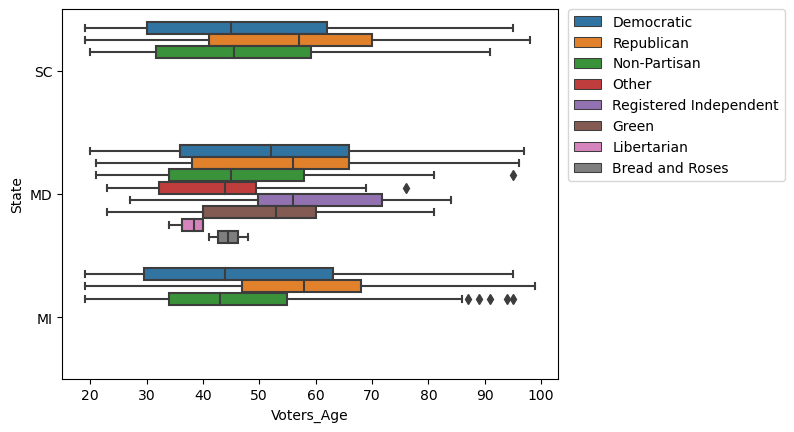

In [65]:
ageplot = sns.boxplot(data=all_pd, x="Voters_Age", y="State", hue="Parties_Description")
ageplot = plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
ageplot

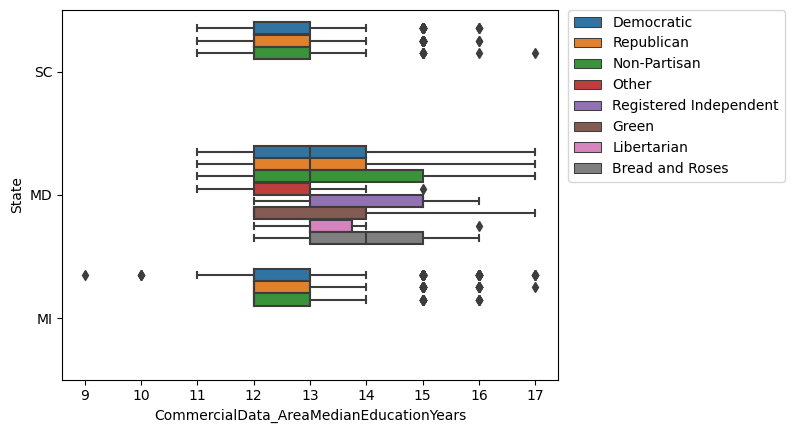

In [66]:
eduplot = sns.boxplot(data=all_pd, x="CommercialData_AreaMedianEducationYears", y="State", hue="Parties_Description")
eduplot = plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
eduplot

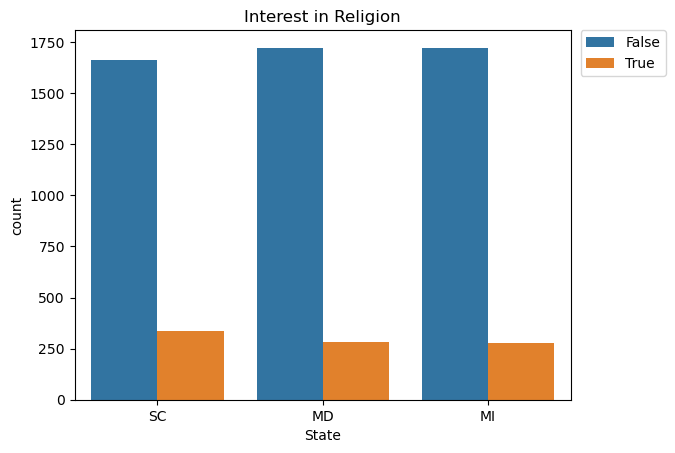

In [75]:

religion_chart = sns.countplot(data=all_pd, x="State",
                             hue="CommercialDataLL_Interest_in_Religious_Inspirational_In_Household").set(title="Interest in Religion")
religion_chart = plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

religion_chart

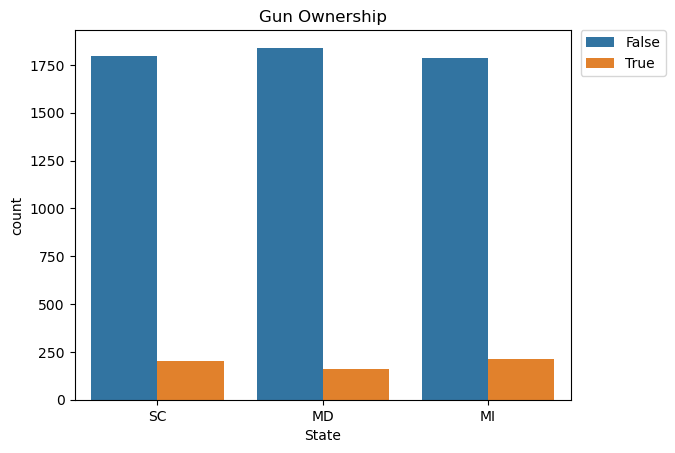

In [76]:
guns_chart = sns.countplot(data=all_pd, x="State",
                             hue="CommercialDataLL_Gun_Owner").set(title="Gun Ownership")
guns_chart = plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

guns_chart

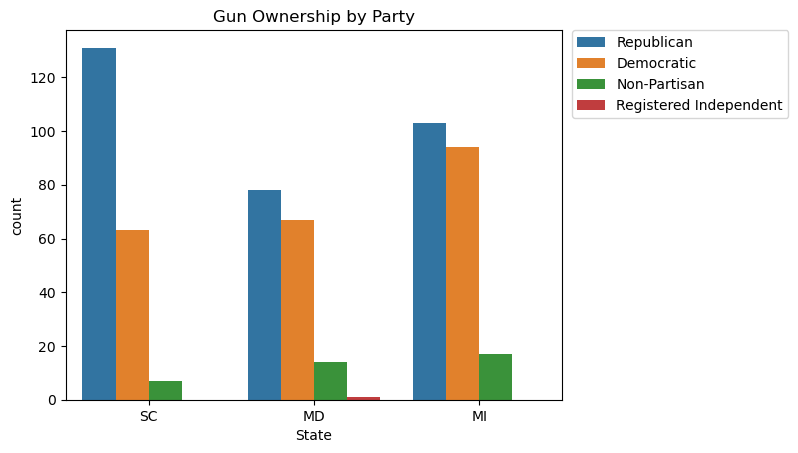

In [77]:
guns_df = all_pd[all_pd["CommercialDataLL_Gun_Owner"]]
guns_party_chart = sns.countplot(data=guns_df, x="State",
                             hue="Parties_Description").set(title="Gun Ownership by Party")
guns_party_chart = plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

guns_party_chart

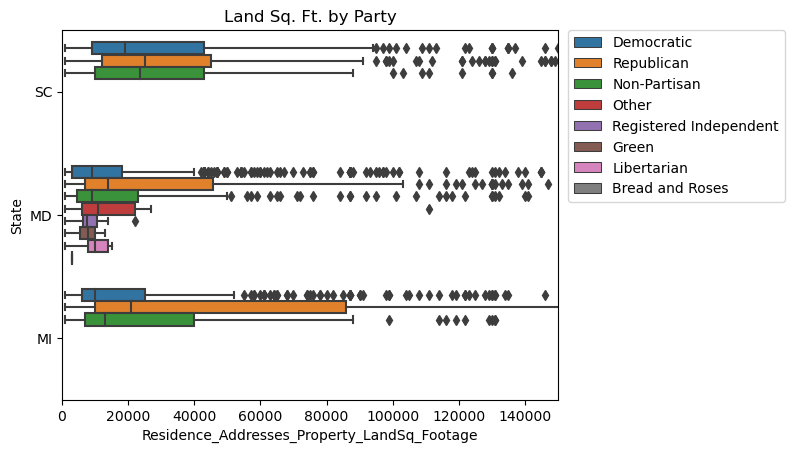

In [92]:
land_plot = sns.boxplot(data=all_pd, x="Residence_Addresses_Property_LandSq_Footage", y="State", hue="Parties_Description")
land_plot.set(title="Land Sq. Ft. by Party")
land_plot.set_xlim(0, 150000)
land_plot = plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

land_plot

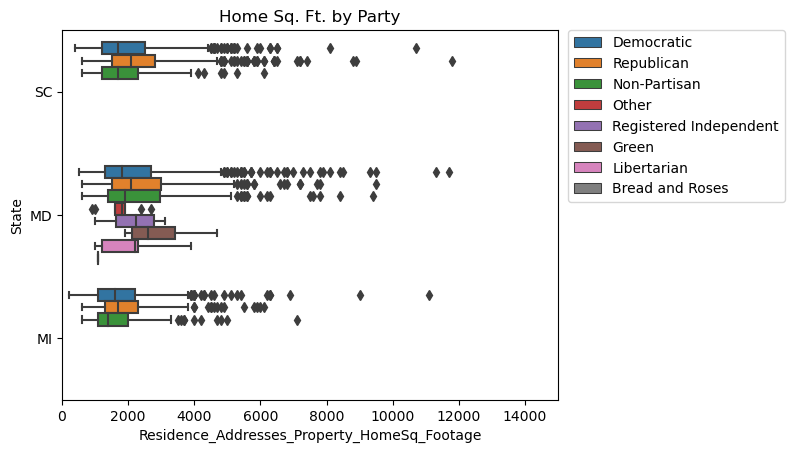

In [94]:
sqft_plot = sns.boxplot(data=all_pd, x="Residence_Addresses_Property_HomeSq_Footage", y="State", hue="Parties_Description")
sqft_plot.set(title="Home Sq. Ft. by Party")
sqft_plot.set_xlim(0, 15000)
sqft_plot = plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

sqft_plot

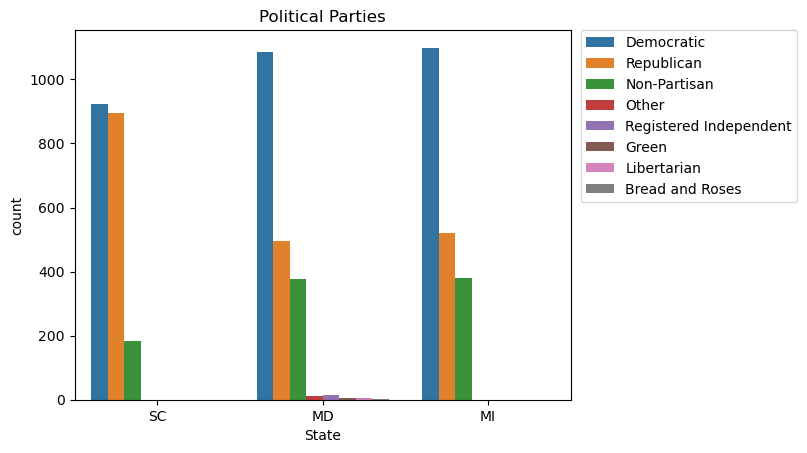

In [95]:
party_chart = sns.countplot(data=all_pd, x="State",
                             hue="Parties_Description").set(title="Political Parties")
party_chart = plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

party_chart

No handles with labels found to put in legend.


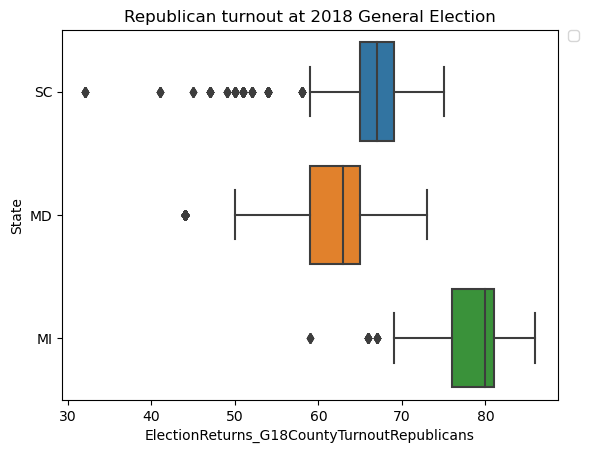

In [108]:

rep_turnout_plot = sns.boxplot(data=all_pd, x="ElectionReturns_G18CountyTurnoutRepublicans", y="State")
rep_turnout_plot.set(title="Republican turnout at 2018 General Election")
rep_turnout_plot = plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

rep_turnout_plot

No handles with labels found to put in legend.


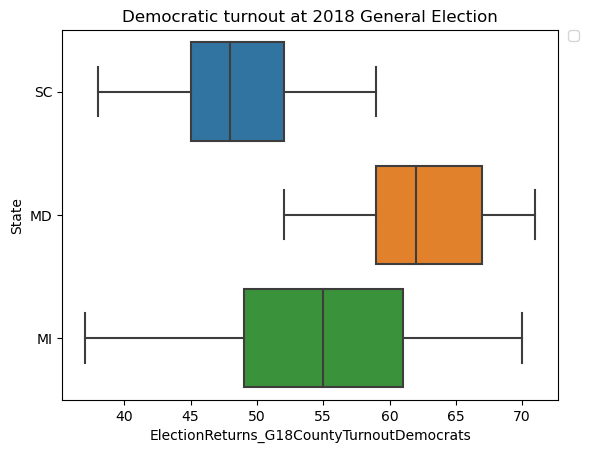

In [109]:
dem_turnout_plot = sns.boxplot(data=all_pd, x="ElectionReturns_G18CountyTurnoutDemocrats", y="State")
dem_turnout_plot.set(title="Democratic turnout at 2018 General Election")
dem_turnout_plot = plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

dem_turnout_plot

In [114]:
turnout_2018 = all_pd[["ElectionReturns_G18CountyTurnoutDemocrats", "ElectionReturns_G18CountyTurnoutRepublicans", "State"]]
turnout_2018 = pd.melt(turnout_2018, id_vars="State", value_vars=["ElectionReturns_G18CountyTurnoutDemocrats", "ElectionReturns_G18CountyTurnoutRepublicans"])
turnout_2018.head()

,State,variable,value
0,SC,ElectionReturns_G18CountyTurnoutDemocrats,51
1,SC,ElectionReturns_G18CountyTurnoutDemocrats,51
2,SC,ElectionReturns_G18CountyTurnoutDemocrats,53
3,SC,ElectionReturns_G18CountyTurnoutDemocrats,50
4,SC,ElectionReturns_G18CountyTurnoutDemocrats,50


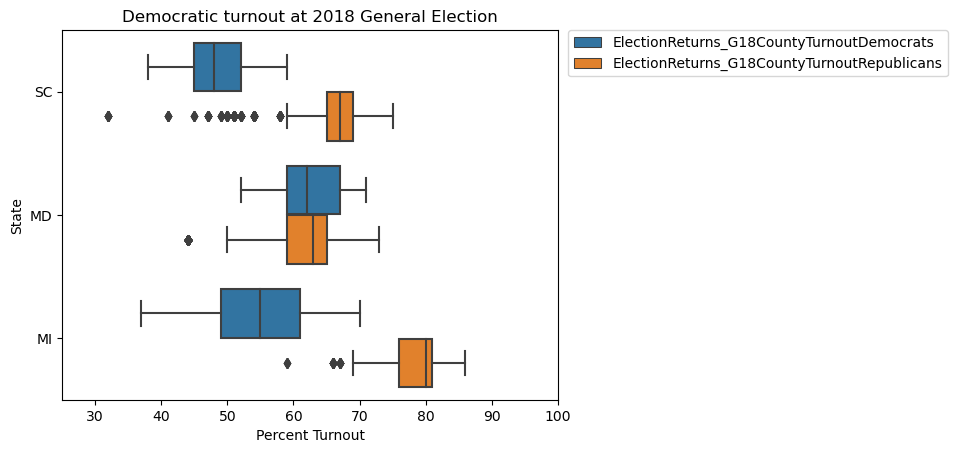

In [119]:
turnout_2018_plot = sns.boxplot(data=turnout_2018, x="value", y="State", hue="variable")
turnout_2018_plot.set(title="Vturnout at 2018 General Election", xlabel="Percent Turnout")
turnout_2018_plot.set_xlim(25,100)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

In [117]:
turnout_2016 = all_pd[["ElectionReturns_G16CountyTurnoutDemocrats", "ElectionReturns_G16CountyTurnoutRepublicans", "State"]]
turnout_2016 = pd.melt(turnout_2016, id_vars="State", value_vars=["ElectionReturns_G16CountyTurnoutDemocrats", "ElectionReturns_G16CountyTurnoutRepublicans"])
turnout_2016.head()



,State,variable,value
0,SC,ElectionReturns_G16CountyTurnoutDemocrats,60
1,SC,ElectionReturns_G16CountyTurnoutDemocrats,60
2,SC,ElectionReturns_G16CountyTurnoutDemocrats,66
3,SC,ElectionReturns_G16CountyTurnoutDemocrats,61
4,SC,ElectionReturns_G16CountyTurnoutDemocrats,61


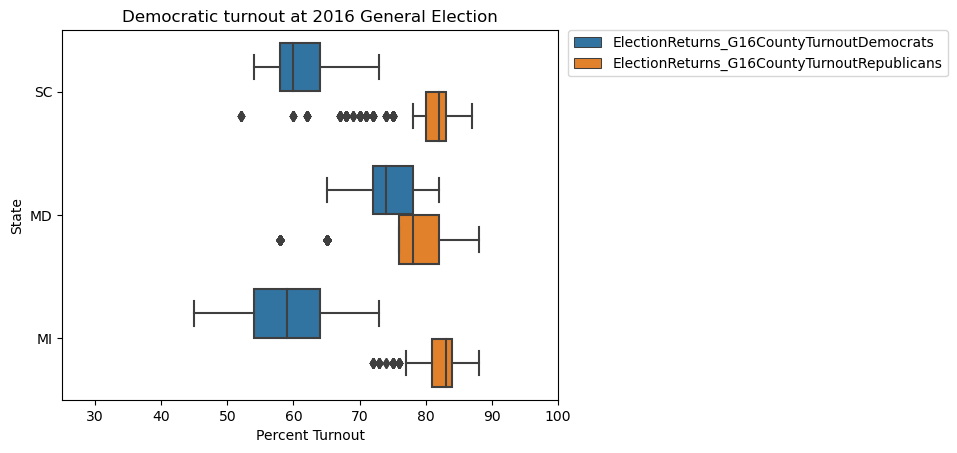

In [121]:
turnout_2016_plot = sns.boxplot(data=turnout_2016, x="value", y="State", hue="variable")
turnout_2016_plot.set(title="Democratic turnout at 2016 General Election", xlabel="Percent Turnout")
turnout_2016_plot.set_xlim(25,100)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)